In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

encoder = LabelEncoder()

In [31]:
df_train['Total Assets'] = df_train['Total Assets'].apply(lambda x: float(x.split()[0]) if 'Crore+' in x else float(x.split()[0]) * 0.01 if 'Lac+' in x else float(x.split()[0]) * 0.0001 if 'Thou+' in x else float(x.split()[0]) * 0.00001 if 'Hund+' in x else 0)
df_train['Liabilities'] = df_train['Liabilities'].apply(lambda x: float(x.split()[0]) if 'Crore+' in x else float(x.split()[0]) * 0.01 if 'Lac+' in x else float(x.split()[0]) * 0.0001 if 'Thou+' in x else float(x.split()[0]) * 0.00001 if 'Hund+' in x else 0)
df_train['SC'] = df_train['Constituency ∇'].apply(lambda x: 1 if '(SC)' in x else 0)
df_train['ST'] = df_train['Constituency ∇'].apply(lambda x: 1 if '(ST)' in x else 0)
df_train['Doctor'] = df_train['Candidate'].apply(lambda x: 1 if 'Dr.' in x else 0)
df_train['Advocate'] = df_train['Candidate'].apply(lambda x: 1 if 'Adv.' in x else 0)

In [32]:
df_test['Total Assets'] = df_test['Total Assets'].apply(lambda x: float(x.split()[0]) if 'Crore+' in x else float(x.split()[0]) * 0.01 if 'Lac+' in x else float(x.split()[0]) * 0.0001 if 'Thou+' in x else float(x.split()[0]) * 0.00001 if 'Hund+' in x else 0)
df_test['Liabilities'] = df_test['Liabilities'].apply(lambda x: float(x.split()[0]) if 'Crore+' in x else float(x.split()[0]) * 0.01 if 'Lac+' in x else float(x.split()[0]) * 0.0001 if 'Thou+' in x else float(x.split()[0]) * 0.00001 if 'Hund+' in x else 0)
df_test['SC'] = df_test['Constituency ∇'].apply(lambda x: 1 if '(SC)' in x else 0)
df_test['ST'] = df_test['Constituency ∇'].apply(lambda x: 1 if '(ST)' in x else 0)
df_test['Doctor'] = df_test['Candidate'].apply(lambda x: 1 if 'Dr.' in x else 0)
df_test['Advocate'] = df_test['Candidate'].apply(lambda x: 1 if 'Adv.' in x else 0)

In [33]:
def extract_names(full_name):
    names = full_name.split()
    Last_name = names[-1]
    first_name = names[0]
    return Last_name

In [34]:
df_train['Party'] = encoder.fit_transform(df_train['Party'])
df_train['state'] = encoder.fit_transform(df_train['state'])
df_train['Candidate'] = encoder.fit_transform(df_train['Candidate'])
df_train['Constituency ∇'] = encoder.fit_transform(df_train['Constituency ∇'])


In [35]:
df_test['Party'] = encoder.fit_transform(df_test['Party'])
df_test['state'] = encoder.fit_transform(df_test['state'])
df_test['Candidate'] = encoder.fit_transform(df_test['Candidate'])
df_test['Constituency ∇'] = encoder.fit_transform(df_test['Constituency ∇'])


In [36]:
df_train['Education'] = encoder.fit_transform(df_train['Education'])

# Get the unique encoded values and corresponding categories
education_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# Decode the encoded values to get educational categories
education_mapping = {value: key for key, value in education_mapping.items()}

In [37]:
Y = df_train['Education']
X = pd.DataFrame(df_train, columns=['SC', 'ST', 'Doctor', 'Advocate', 'Party', 'Criminal Case', 'Total Assets', 'state'])
X_test = pd.DataFrame(df_test, columns=['SC', 'ST', 'Doctor', 'Advocate', 'Party', 'Criminal Case', 'Total Assets','state'])

In [38]:
def detect_outliers(df):
    outlier_indices = []
    for col in df.columns:
        if df[col].dtype != 'object':
            Q1 = np.percentile(df[col], .1)
            Q3 = np.percentile(df[col], 99.9)
            IQR = Q3 - Q1
            outlier_step = 1.5* IQR
            outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
            outlier_indices.extend(outlier_list_col)
    outlier_indices = list(set(outlier_indices))
    return outlier_indices
def mitigate_outliers(df, outliers_indices):
    for col in df.columns:
        if df[col].dtype != 'object':
            mode = df[col].mode()
            df.loc[outliers_indices, col] = mode
    return df

In [39]:
outliers_train = detect_outliers(X)
outliers_indices = list(set(outliers_train))
X = mitigate_outliers(X, outliers_indices)


In [40]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, random_state=0)

In [41]:
classifier = RandomForestClassifier(n_estimators=420, max_depth=50, min_samples_split=11, random_state=42)
classifier.fit(X_train, Y_train)
Y_val_obt = classifier.predict(X_val)
Y_test = classifier.predict(X_test)

In [42]:
y_pred_decoded = [education_mapping[label] for label in Y_test]
predictions_df = pd.DataFrame({'ID': df_test['ID'], 'Education': y_pred_decoded})
predictions_df.to_csv('pred.csv', index=False)

In [43]:
f1=f1_score(Y_val, Y_val_obt, average='weighted')
f1

0.19567160652905793

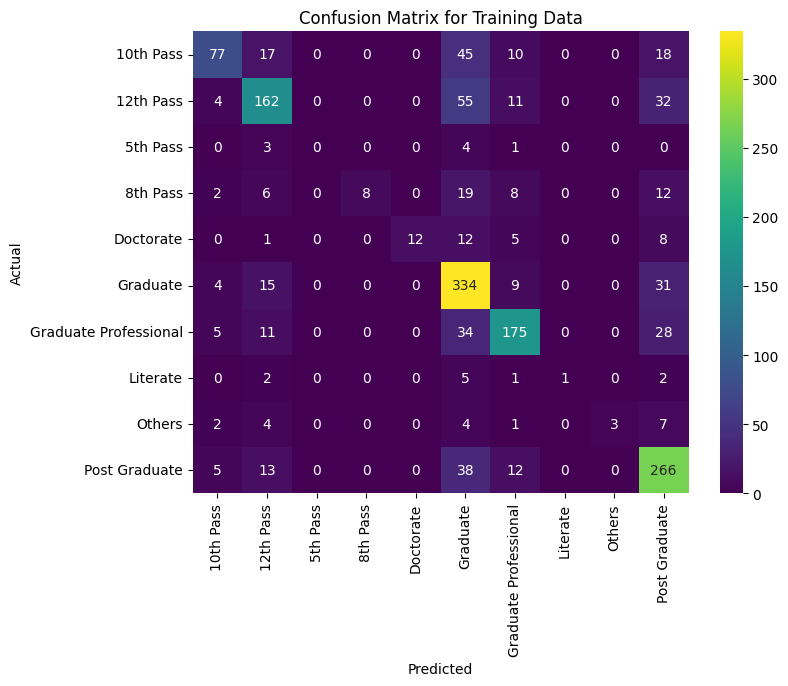

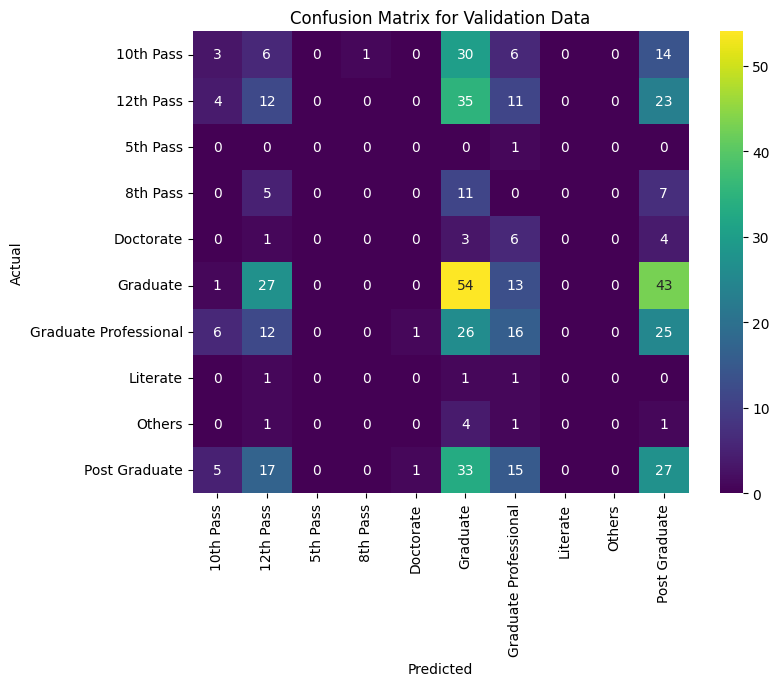

In [45]:
train_conf_matrix = confusion_matrix(Y_train, classifier.predict(X_train))
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=education_mapping.values(), yticklabels=education_mapping.values())
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

val_conf_matrix = confusion_matrix(Y_val, Y_val_obt)
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=education_mapping.values(), yticklabels=education_mapping.values())
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



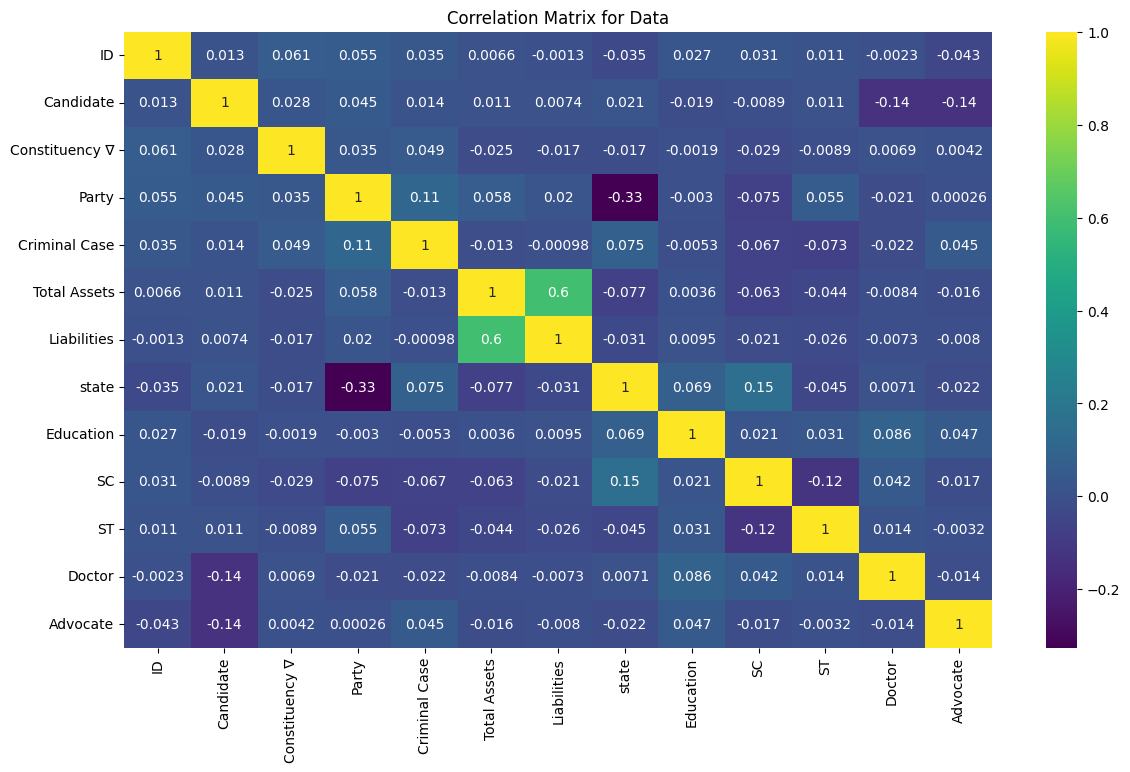

In [46]:
corr_matrix = df_train.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix for Data')
plt.show()